### Initial Setup

Code written by Maxim Grinin

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Essential
import pandas as pd
import numpy as np
from datetime import datetime
import calendar

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Statistical
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima_model import ARMA, ARIMA
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima

# Metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

# Plotting setup
sns.set_theme(style = 'whitegrid')
#plt.rc('figure',figsize = (16,12))
#plt.rc('font',size = 15)

#### #1 Data

In [3]:
# DateParser Setup
dateparse = lambda x: datetime.strptime(x, '%d.%m.%Y')
# Reading initial dataset, putting dates into indexes
df = pd.read_excel('Centr.xlsx', parse_dates=[1], date_parser = dateparse, index_col = 'Дата')

# Selecting target column
df = df.iloc[:, [1]]

# Renaming column with traget for convinience
df.rename(columns = {df.columns[0]:'target'}, inplace = True)
df.index.names = ['date']

# Seelcting date rnage to work with
data = df.loc['2016-02-01':]

data.head(8)

,target
date,
2016-02-01,707386.95
2016-02-02,704594.37
2016-02-03,698593.50
2016-02-04,694674.58
2016-02-05,700368.77
2016-02-06,668650.85
2016-02-07,660824.38
2016-02-08,697214.88


#### #2 Detrending 

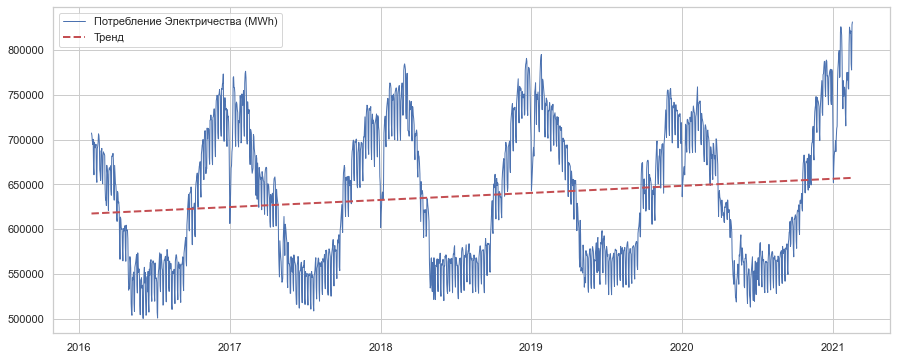

In [4]:
# Trend setting

## Time array setting
t = np.array(range(len(data))).reshape(-1,1)
## Linear regression / fitting / trend / residuals extraction
tr_reg = LinearRegression()
tr_reg.fit(t, data['target'])
trend = tr_reg.predict(t)
data['linreg_resid'] = data['target'] - trend

# Plotting the data with trend
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['target'], linewidth = 1, label = 'Потребление Электричества (MWh)')
plt.plot(data.index, trend, 'r--', linewidth = 2.0, label = 'Тренд')
plt.legend()
plt.show()

In [5]:
print('The Linear trend accounts {:.4}% of the data dispersion'.format(r2_score(data['target'], trend)*100))

The Linear trend accounts 2.23% of the data dispersion


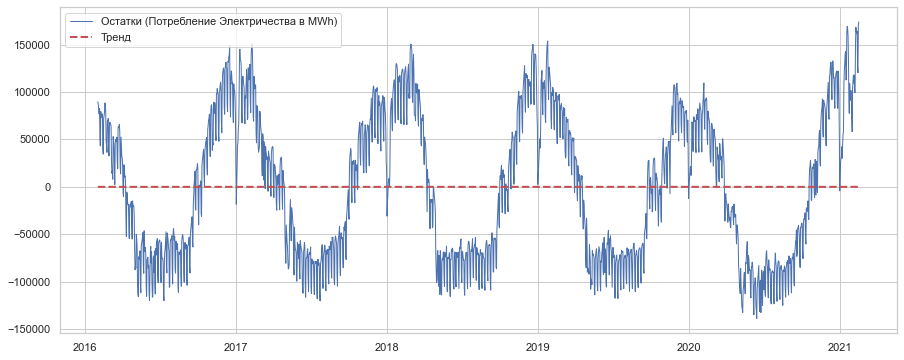

In [6]:
# Trend setting
trend_resid = np.array([0]*len(data))

# Plotting the data with trend
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['linreg_resid'], linewidth = 1, label = 'Остатки (Потребление Электричества в MWh)')
plt.plot(data.index, trend_resid, 'r--', linewidth = 2.0, label = 'Тренд')
plt.legend()
plt.show()

#### #3 Harmonic Function

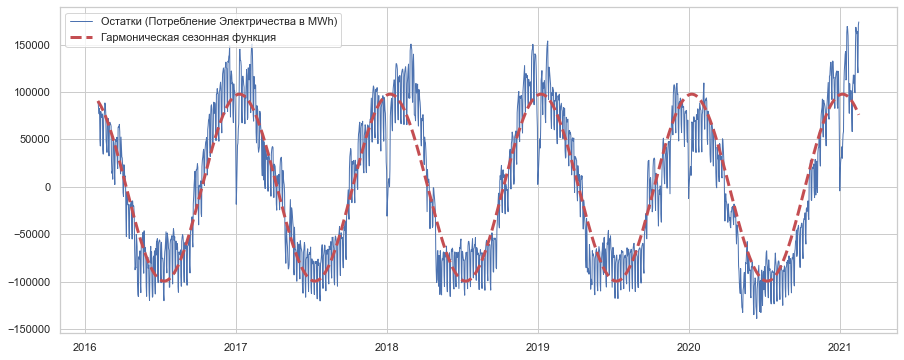

In [7]:
# Cosinusoid & Sinusoid
cos = np.cos((2*np.pi/365)*(t))
sin = np.sin((2*np.pi/365)*(t))
cos_sin = np.hstack((cos, sin))

# Amplitude & Shift
s_reg = LinearRegression()
s_reg.fit(cos_sin, data['linreg_resid'])
amplitude = s_reg.coef_
shift = s_reg.intercept_

# Final harmonic function
yearly_seas = np.sum(amplitude * cos_sin, axis=1) + shift

# Plotting result
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['linreg_resid'], linewidth = 1, label = 'Остатки (Потребление Электричества в MWh)')
plt.plot(data.index, yearly_seas, 'r--', linewidth = 3, label = 'Гармоническая сезонная функция')
plt.legend()
plt.show()

In [8]:
print('The yearly seasonality accounts {:.4}% of the data dispersion'.format(r2_score(data['target'], (yearly_seas+trend))*100))

The yearly seasonality accounts 84.65% of the data dispersion


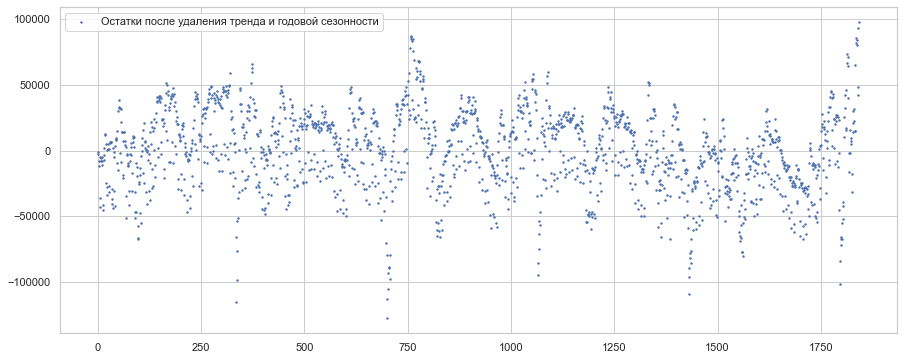

In [9]:
# Residuals Graph
data['harm_resid'] = data['linreg_resid'] - yearly_seas

plt.figure(figsize=(15, 6))
plt.scatter(t, data['harm_resid'], s = 2, label = 'Остатки после удаления тренда и годовой сезонности')
plt.legend()
plt.show()

#### #4 Weekday Dummies

In [10]:
# Adding day of the week into data set
data['weekday'] = data.index.dayofweek

wd_name = list(calendar.day_abbr)
wd_num = list(range(7))
wd_dict = dict(zip(wd_num, wd_name))
data['weekday'].replace(wd_dict, inplace=True)
data.head()

,target,linreg_resid,harm_resid,weekday
date,,,,
2016-02-01,707386.95,89761.111019,-790.129691,Mon
2016-02-02,704594.37,86946.938803,-2955.647332,Tue
2016-02-03,698593.50,80924.476587,-8302.569816,Wed
2016-02-04,694674.58,76983.964371,-11540.857319,Thu
2016-02-05,700368.77,82656.562156,-5139.557925,Fri


In [11]:
# Dummy variables for day of the week
weekday_dummy = pd.get_dummies(data['weekday'])
weekday_dummy.head(7)

,Fri,Mon,Sat,Sun,Thu,Tue,Wed
date,,,,,,,
2016-02-01,0,1,0,0,0,0,0
2016-02-02,0,0,0,0,0,1,0
2016-02-03,0,0,0,0,0,0,1
2016-02-04,0,0,0,0,1,0,0
2016-02-05,1,0,0,0,0,0,0
2016-02-06,0,0,1,0,0,0,0
2016-02-07,0,0,0,1,0,0,0


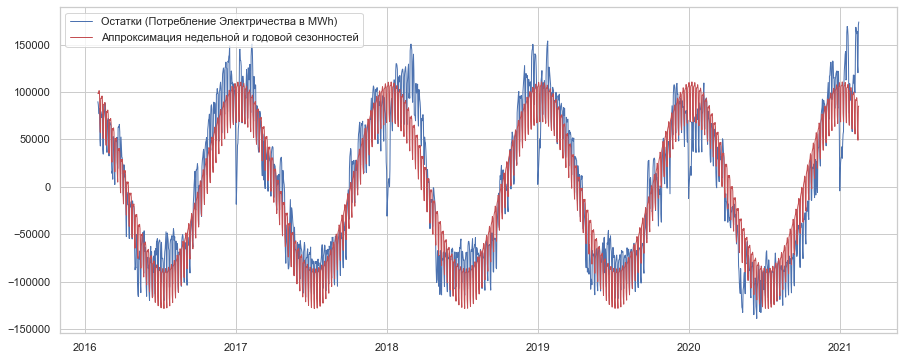

In [12]:
# Seasonal regression for day of the week
s_reg = LinearRegression()
s_reg.fit(weekday_dummy, data['linreg_resid'])
weekly_seas = s_reg.predict(weekday_dummy)

seas = yearly_seas + weekly_seas
data['seas_resid'] = data['linreg_resid'] - seas
# Plotting result
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['linreg_resid'], linewidth = 1, label = 'Остатки (Потребление Электричества в MWh)')
plt.plot(data.index, seas, 'r', linewidth = 1, label = 'Аппроксимация недельной и годовой сезонностей')
plt.legend()
plt.show()

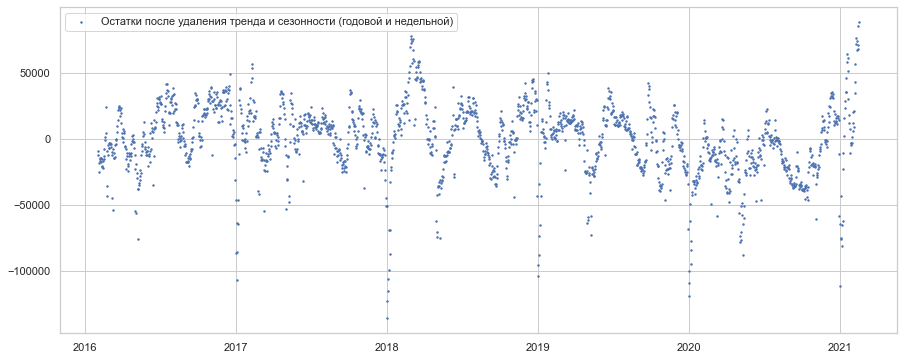

In [13]:
plt.figure(figsize=(15, 6))
plt.scatter(data.index, data['seas_resid'], s = 2, label = 'Остатки после удаления тренда и сезонности (годовой и недельной)')
plt.legend()
plt.show()

In [14]:
print('The weekly seasonality accounts {:.4}% of the data dispersion'.format(r2_score(data['linreg_resid'], weekly_seas)*100))
print('The yearly + weekly seasonality accounts {:.4}% of the data dispersion'.format(r2_score(data['linreg_resid'], seas)*100))

The weekly seasonality accounts 4.023% of the data dispersion
The yearly + weekly seasonality accounts 88.3% of the data dispersion


##### Visual representation of seasonal-trend decomposition

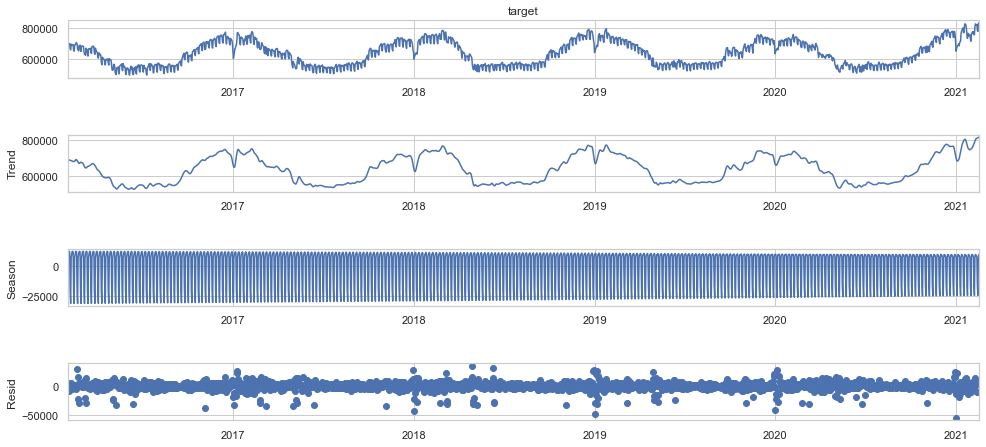

In [15]:
# Auto STL
stl = STL(data['target'], seasonal=365)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(16, 7)

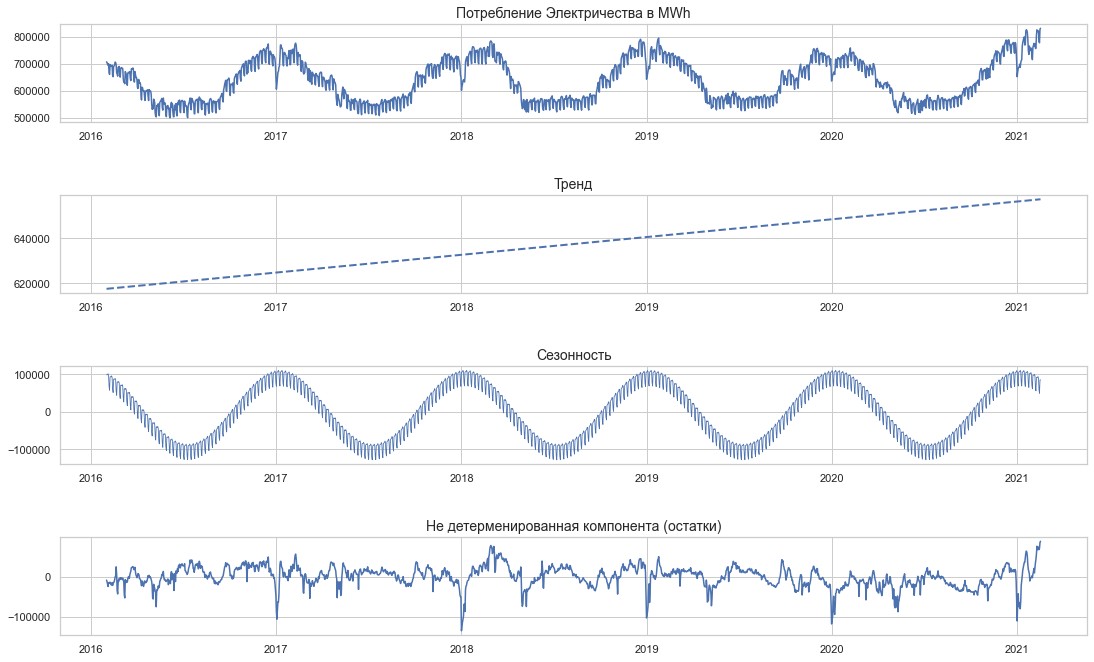

In [16]:
# Manual Seasonal-Trend Decomposition

x = data.index

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
ax1.plot(x, data['target'])
ax2.plot(x, trend, 'C0--', linewidth = 2)
ax3.plot(x, seas, linewidth = 0.8)
ax4.plot(x, data['seas_resid'], markersize=1)

ax1.set_title('Потребление Электричества в MWh', fontsize=14)
ax2.set_title('Тренд', fontsize=14)
ax3.set_title('Сезонность', fontsize=14)
ax4.set_title('Не детерменированная компонента (остатки)', fontsize=14)

fig.set_size_inches(16, 10)
fig.tight_layout(pad=3.0)

#### #5 Residuals Stationary Tests

In [17]:
X = data['seas_resid']

# ADF, initial data
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.519443
p-value: 0.000002
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


ADF test p-value is small enough to reject $H_0$ = {a unit root is present in a time series sample} -> data is stationary

KPSS test supports ADF test result

#### #6 ACF, PACF, ARMA order

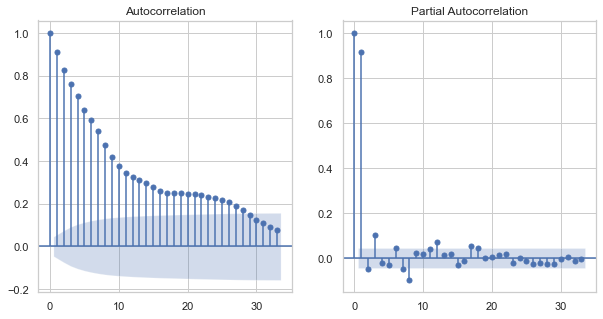

In [18]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
plot_acf(data['seas_resid'], ax = ax1)
plot_pacf(data['seas_resid'], ax = ax2)

As we can see, acf decreases exponentially and on paf graph we see only 2-3 significant spikes, meaning that all the higher-order autocorrelations are effectively explained by the lag-$2$ or lag-$3$
autocorrelation. $ARMA(3,0)$

#### #7-9 ARMA/ARIMA modeling

In [19]:
# Loop over p values from 1-4
for p in range(1,5):
  # Loop over q values from 1-3
    for q in range(1,4):
        # create and fit ARMA(p,q) model
        try:
            model = ARMA(data['seas_resid'], order=(p,q), freq='D')
            results = model.fit()
            aic = round(results.aic, 2)
            print('ARMA({}, {}); AIC: {}'.format(p, q, aic))
        except:
            pass
        
        
        # Append order and results tuple
        #print('({}, {}); AIC: {}, BIC: {}'.format(p, q, aic, biq))

ARMA(1, 1); AIC: 39352.92
ARMA(1, 2); AIC: 39337.04
ARMA(1, 3); AIC: 39339.04
ARMA(2, 1); AIC: 39346.5
ARMA(2, 2); AIC: 39339.04
ARMA(3, 1); AIC: 39337.37
ARMA(3, 2); AIC: 39326.37
ARMA(4, 1); AIC: 39339.57
ARMA(4, 2); AIC: 39327.29
ARMA(4, 3); AIC: 39329.18


In [20]:
# Loop over p values from 1-4
for p in range(1,5):
  # Loop over в values from 1-3
    for d in range(1,4):
     # Loop over q values from 1-3
        for q in range(1,4):
            # create and fit ARIMA(p,d,q) model
            try:
                model = ARIMA(data['seas_resid'], order=(p,d,q), freq='D')
                results = model.fit()
                aic = round(results.aic, 2)
                print('ARIMA({}, {}, {}); AIC: {}'.format(p, d, q, aic))
            except:
                pass

ARIMA(1, 1, 1); AIC: 39338.56
ARIMA(1, 1, 2); AIC: 39371.3
ARIMA(2, 1, 1); AIC: 39372.73
ARIMA(2, 1, 2); AIC: 39328.41
ARIMA(2, 2, 1); AIC: 39360.49
ARIMA(2, 2, 2); AIC: 39362.07
ARIMA(3, 1, 1); AIC: 39374.17
ARIMA(3, 1, 2); AIC: 39319.7
ARIMA(3, 1, 3); AIC: 39308.48
ARIMA(3, 2, 1); AIC: 39362.17
ARIMA(3, 2, 2); AIC: 39363.49
ARIMA(4, 1, 1); AIC: 39319.32
ARIMA(4, 1, 2); AIC: 39321.96


/Users/neteplo/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


ARIMA(4, 1, 3); AIC: 39309.5
ARIMA(4, 2, 1); AIC: 39364.05
ARIMA(4, 2, 2); AIC: 39365.32


In [21]:
arma_32 = ARMA(data['seas_resid'], order = (3, 2), freq = 'D')
res_32 = arma_32.fit()
res_32.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             seas_resid   No. Observations:                 1843
Model:                     ARMA(3, 2)   Log Likelihood              -19656.185
Method:                       css-mle   S.D. of innovations          10361.544
Date:                Sat, 08 May 2021   AIC                          39326.369
Time:                        18:02:22   BIC                          39365.003
Sample:                    02-01-2016   HQIC                         39340.614
                         - 02-16-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -27.4682   2941.060     -0.009      0.993   -5791.840    5736.903
ar.L1.seas_resid     0.1918      0.162      1.182      0.237      -0.126       0.510
ar.L2.seas_resid    -0.0530      0.108     -0.490      0.624      -0.265       0.159
ar.L3.seas_resid     0.6598      0.075      8.849      0.000       0.514       0.806
ma.L1.seas_resid     0.7910      0.171      4.618      0.000       0.455       1.127
ma.L2.seas_resid     0.6772      0.104      6.523      0.000       0.474       0.881
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0898           -0.0000j            1.0898           -0.0000
AR.2           -0.5047           -1.0658j            1.1793           -0.3204
AR.3           -0.5047           +1.0658j            1.1793            0.3204
MA.1           -0.5840           -1.0656j            1.2151           -0.3298
MA.2           -0.5840           +1.0656j            1.2151            0.3298
-----------------------------------------------------------------------------
"""

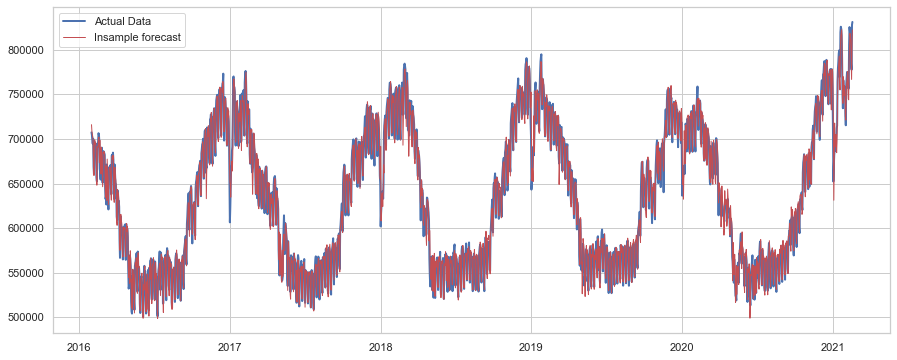

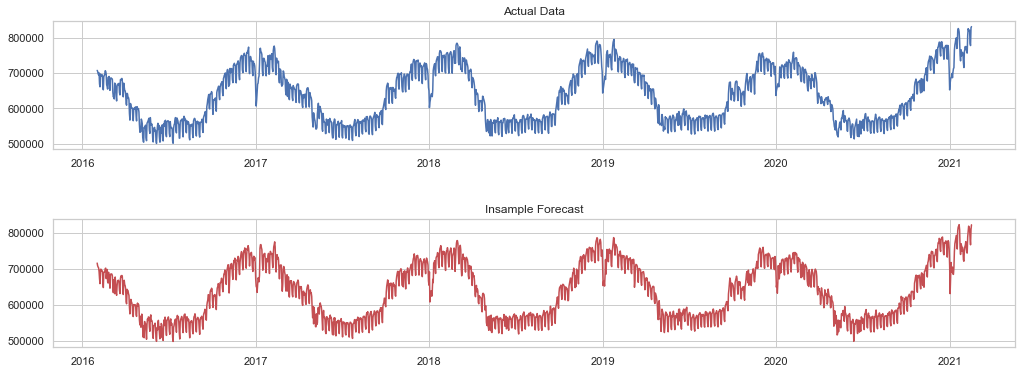

In [22]:
# Make insample forecat
resid_arma = res_32.predict(start=data.index[0], end=data.index[-1])
forecast_arma = seas + resid_arma + trend 

# Plotting forecast
plt.figure(figsize=(15, 6))
plt.plot(x, data['target'], label = 'Actual Data', linewidth=2)
plt.plot(x, forecast_arma, color='r', label = 'Insample forecast', linewidth=1)
plt.legend()
plt.show()


# Just anither way to plot
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(x, data['target'])
ax2.plot(x, forecast_arma, color = 'r')


ax1.set_title('Actual Data')
ax2.set_title('Insample Forecast')

fig.set_size_inches(15, 6)
fig.tight_layout(pad=3.0)
plt.show()

In [23]:
print('ARMA(3,2) losses:\nRMSE: {}, MAPE: {:.3}'.format(round(rmse(data['target'], forecast_arma),2), 
                                                        mape(data['target'], forecast_arma)))

ARMA(3,2) losses:
RMSE: 10363.25, MAPE: 0.0103


In [24]:
arima_312 = ARIMA(data['seas_resid'], order = (3, 1, 2), freq = 'D')
res_312 = arima_312.fit()
res_312.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.seas_resid   No. Observations:                 1842
Model:                 ARIMA(3, 1, 2)   Log Likelihood              -19652.850
Method:                       css-mle   S.D. of innovations          10396.291
Date:                Sat, 08 May 2021   AIC                          39319.700
Time:                        18:02:25   BIC                          39358.331
Sample:                    02-02-2016   HQIC                         39333.944
                         - 02-16-2021                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -7.5266      5.640     -1.335      0.182     -18.581       3.528
ar.L1.D.seas_resid     0.8442      0.166      5.073      0.000       0.518       1.170
ar.L2.D.seas_resid    -0.0318      0.163     -0.195      0.846      -0.352       0.288
ar.L3.D.seas_resid     0.0985      0.025      3.866      0.000       0.049       0.148
ma.L1.D.seas_resid    -0.8765      0.167     -5.264      0.000      -1.203      -0.550
ma.L2.D.seas_resid    -0.1234      0.166     -0.741      0.458      -0.450       0.203
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0812           -0.0000j            1.0812           -0.0000
AR.2           -0.3792           -3.0416j            3.0651           -0.2697
AR.3           -0.3792           +3.0416j            3.0651            0.2697
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -8.1005           +0.0000j            8.1005            0.5000
-----------------------------------------------------------------------------
"""

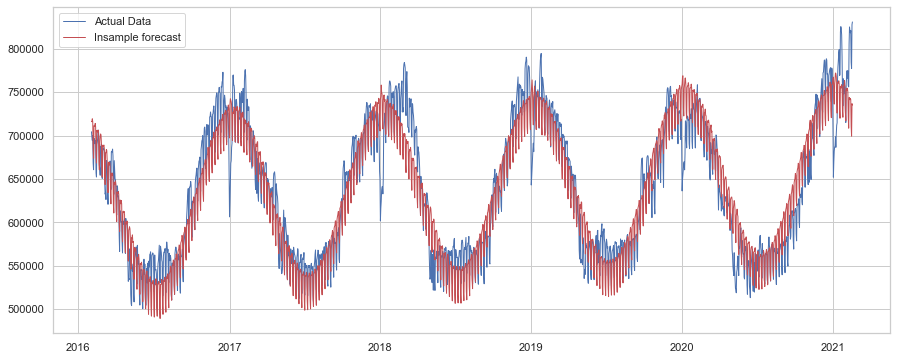

In [25]:
# Make insample forecat
resid_arima = res_312.predict(start=data.index[1], end=data.index[-1])
forecast_arima = seas[1:] + resid_arima + trend[1:]

# Plotting forecast
plt.figure(figsize=(15, 6))
plt.plot(x[1:], data['target'].iloc[1:, ], label = 'Actual Data', linewidth=1)
plt.plot(x[1:], forecast_arima, color='r', label = 'Insample forecast', linewidth=1)
plt.legend()
plt.show()

In [26]:
print('ARIMA(3,1,2) losses:\nRMSE: {}, MAPE: {:.3}'.format(round(rmse(data['target'].iloc[1:,], forecast_arima),2), 
                                                           mape(data['target'].iloc[1:,], forecast_arima)))

ARIMA(3,1,2) losses:
RMSE: 27903.68, MAPE: 0.033


#### #10 Auto ARIMA

In [27]:
auto = auto_arima(data['seas_resid'], seasonal = False)
auto_res = auto.fit(data['seas_resid'])
auto_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1843
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -19700.979
Date:                Sat, 08 May 2021   AIC                          39403.959
Time:                        18:02:27   BIC                          39409.477
Sample:                             0   HQIC                         39405.994
                               - 1843                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.141e+08   1.62e+06     70.299      0.000    1.11e+08    1.17e+08
===================================================================================
Ljung-Box (Q):                      123.00   Jarque-Bera (JB):              5966.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.61
Prob(H) (two-sided):                  0.58   Kurtosis:                        11.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

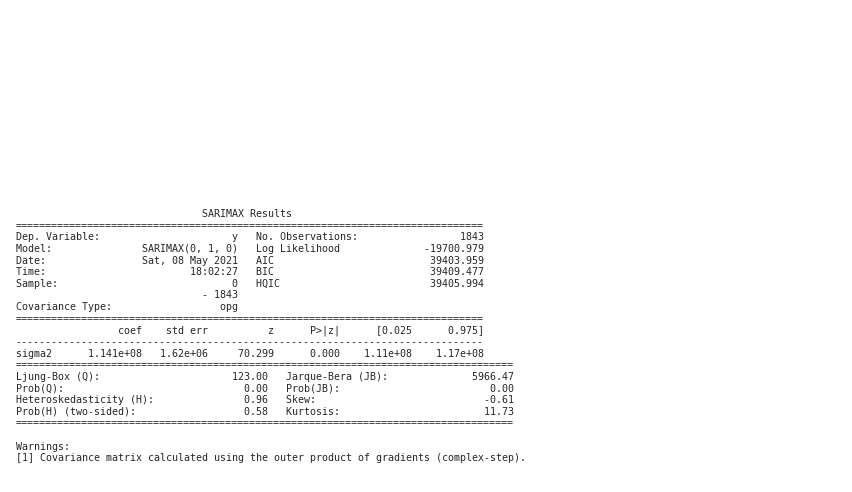

In [28]:
plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(auto.summary()), {'fontsize': 12}) #old approach
plt.text(0.01, 0.05, str(auto.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()

In [29]:
auto = auto_arima(data['seas_resid'], seasonal = False)
auto_res = auto.fit(data['seas_resid'])
auto_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1843
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -19700.979
Date:                Sat, 08 May 2021   AIC                          39403.959
Time:                        18:02:31   BIC                          39409.477
Sample:                             0   HQIC                         39405.994
                               - 1843                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.141e+08   1.62e+06     70.299      0.000    1.11e+08    1.17e+08
===================================================================================
Ljung-Box (Q):                      123.00   Jarque-Bera (JB):              5966.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.61
Prob(H) (two-sided):                  0.58   Kurtosis:                        11.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""